# Salinity Prediction

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

## Setup ad Load Data

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load salinity data
print("Loading salinity data from CSV...")
df = pd.read_csv('salinity_data.csv')

# Display column names to verify
print(f"\nColumn names in CSV: {df.columns.tolist()}")

# Map column names to standard names
# Data has transfer function H(ω)
column_mapping = {
    'freq': 'frequency',
    'amp': 'input_amplitude', 
    'mag': 'transfer_magnitude',
    'phase': 'phase',
    'salinity': 'salinity'
}

# Rename columns
df = df.rename(columns=column_mapping)

Loading salinity data from CSV...

Column names in CSV: ['freq', 'amp', 'mag', 'phase', 'salinity']


## Dataset Overview

In [3]:
print(f"Shape: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nStatistics:")
print(df.describe())

# Check for missing values
if df.isnull().any().any():
    print("\nMissing values detected")
    print(df.isnull().sum())
    print("\nDropping rows with missing values")
    df = df.dropna()
    print(f"New shape: {df.shape}")

Shape: 150 samples, 5 features

First 10 rows:
   frequency  input_amplitude  transfer_magnitude    phase  salinity
0     1.0000           0.4978              0.5948 -17.7966      17.5
1     1.0000           0.6978              0.5705 -19.8178      17.5
2     1.0000           0.8978              0.5503 -19.9723      17.5
3     1.0000           1.0978              0.5763 -17.4270      17.5
4     1.0000           1.2967              0.5933 -15.5371      17.5
5     1.0000           1.4967              0.6108 -14.4578      17.5
6    21.0083           1.4967              0.2852 -26.4927      17.5
7    21.0081           1.2967              0.2731 -27.8105      17.5
8    21.0082           1.0978              0.2616 -29.4914      17.5
9    21.0082           0.8978              0.2507 -30.6301      17.5

Statistics:
        frequency  input_amplitude  transfer_magnitude       phase    salinity
count  150.000000       150.000000          150.000000  150.000000  150.000000
mean    38.110649      

## Feature Preparation

In [4]:
# Prepare features and target
X = df[['input_amplitude', 'frequency', 'transfer_magnitude', 'phase']].values
y = df['salinity'].values

print(f"\nSalinity range: {y.min():.3f} to {y.max():.3f}")
print(f"Input amplitude range: {X[:, 0].min():.3f}V to {X[:, 0].max():.3f}V")
print(f"Frequency range: {X[:, 1].min():.1f}Hz to {X[:, 1].max():.1f}Hz")
print(f"Transfer function |H| range: {X[:, 2].min():.4f} to {X[:, 2].max():.4f}")
print(f"Phase range: {X[:, 3].min():.2f}° to {X[:, 3].max():.2f}°")

# Convert transfer function to impedance (voltage divider with R=100Ω)
# H = Z/(100 + Z)  =>  Z = 100*H/(1-H)
R_series = 100  # Series resistor in voltage divider

H_mag = X[:, 2]
H_phase_deg = X[:, 3]
H_phase_rad = np.deg2rad(H_phase_deg)

# Complex transfer function: H = |H| * e^(j*phase)
H_real = H_mag * np.cos(H_phase_rad)
H_imag = H_mag * np.sin(H_phase_rad)

# Z = R * H / (1 - H)
# For complex: Z = R * (H_real + j*H_imag) / ((1-H_real) - j*H_imag)
denom_real = 1 - H_real
denom_imag = -H_imag

# Complex division: (a + jb) / (c + jd) = [(ac+bd) + j(bc-ad)] / (c^2+d^2)
denom_mag_sq = denom_real**2 + denom_imag**2

Z_real = R_series * (H_real * denom_real + H_imag * denom_imag) / denom_mag_sq
Z_imag = R_series * (H_imag * denom_real - H_real * denom_imag) / denom_mag_sq

# Impedance magnitude and phase
Z_magnitude = np.sqrt(Z_real**2 + Z_imag**2)
Z_phase_rad = np.arctan2(Z_imag, Z_real)
Z_phase_deg = np.degrees(Z_phase_rad)

# Add impedance to dataframe for reference
df['impedance_magnitude'] = Z_magnitude
df['impedance_phase'] = Z_phase_deg

print(f"\nCalculated Impedance |Z| range: {Z_magnitude.min():.2f}Ω to {Z_magnitude.max():.2f}Ω")
print(f"Calculated Impedance phase range: {Z_phase_deg.min():.2f}° to {Z_phase_deg.max():.2f}°")

# Check if we have enough data
if len(df) < 50:
    print(f"\nOnly {len(df)} samples. Model may underfit.")

X_combined = np.column_stack([
    X,  # Original: input_amp, freq, |H|, H_phase
    Z_magnitude,  # Calculated impedance magnitude
    Z_phase_deg   # Calculated impedance phase
])

# Split data (75% train, 25% test)
test_size = 0.25 if len(df) >= 40 else 0.2  # Use smaller test set if data is limited
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=test_size, random_state=42
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Salinity range: 17.500 to 26.300
Input amplitude range: 0.498V to 1.497V
Frequency range: 1.0Hz to 66.3Hz
Transfer function |H| range: 0.1861 to 0.7109
Phase range: -36.28° to -14.09°

Calculated Impedance |Z| range: 21.75Ω to 199.66Ω
Calculated Impedance phase range: -51.46° to -30.94°

Training samples: 112
Testing samples: 38


## Feature Engineering

In [7]:
# Feature engineering adapted for transfer function + impedance
omega_train = 2 * np.pi * X_train[:, 1]
omega_test = 2 * np.pi * X_test[:, 1]

# Transfer function features
H_mag_train = X_train[:, 2]
H_mag_test = X_test[:, 2]
H_phase_rad_train = np.deg2rad(X_train[:, 3])
H_phase_rad_test = np.deg2rad(X_test[:, 3])

# Impedance features (already calculated)
Z_mag_train = X_train[:, 4]
Z_mag_test = X_test[:, 4]
Z_phase_rad_train = np.deg2rad(X_train[:, 5])
Z_phase_rad_test = np.deg2rad(X_test[:, 5])

# Add engineered features combining both representations
X_train_eng = np.column_stack([
    X_train,                        # Original 6 features
    1/X_train[:, 1],                # 1/freq
    Z_mag_train * omega_train,      # Z*ω (related to capacitance)
    1/(Z_mag_train * omega_train),  # 1/(Z*ω) ~ capacitance
    np.sin(Z_phase_rad_train),      # sin(Z_phase)
    np.cos(Z_phase_rad_train),      # cos(Z_phase)
])

X_test_eng = np.column_stack([
    X_test,
    1/X_test[:, 1],
    Z_mag_test * omega_test,
    1/(Z_mag_test * omega_test),
    np.sin(Z_phase_rad_test),
    np.cos(Z_phase_rad_test),
])

## Define Model

In [8]:
# Define models
models = {
    'Random Forest (n=30)': RandomForestRegressor(
        n_estimators=30, max_depth=8, min_samples_split=max(2, len(X_train)//20),
        min_samples_leaf=max(1, len(X_train)//40), random_state=42
    ),
    'Random Forest (n=50)': RandomForestRegressor(
        n_estimators=50, max_depth=10, min_samples_split=max(2, len(X_train)//20),
        min_samples_leaf=max(1, len(X_train)//40), random_state=42
    ),
    'Random Forest (n=100)': RandomForestRegressor(
        n_estimators=100, max_depth=12, min_samples_split=max(2, len(X_train)//15),
        min_samples_leaf=max(1, len(X_train)//30), random_state=42
    )
}

results = {}

## Model Evaluation

In [10]:

for name, model in models.items():
    X_tr, X_te = X_train_eng, X_test_eng
   
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation (adjust folds for small datasets)
    cv_folds = min(5, len(X_train) // 10)
    if cv_folds >= 2:
        cv_scores = cross_val_score(
            model, X_tr, y_train, cv=cv_folds, 
            scoring='neg_mean_absolute_error'
        )
        cv_mae = -cv_scores.mean()
        cv_std = cv_scores.std()
    else:
        cv_mae = np.nan
        cv_std = np.nan
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'cv_mae': cv_mae,
        'cv_std': cv_std
    }
    
    print(f"\n{name}:")
    print(f"  Test MAE:  {mae:.4f}")
    print(f"  Test MAPE: {mape:.2f}%")
    print(f"  Test R^2:   {r2:.4f}")
    if not np.isnan(cv_mae):
        print(f"  CV MAE:    {cv_mae:.4f} ± {cv_std:.4f}")


Random Forest (n=30):
  Test MAE:  3.1357
  Test MAPE: 15.57%
  Test R^2:   -0.2683
  CV MAE:    2.5855 ± 0.2022

Random Forest (n=50):
  Test MAE:  3.0710
  Test MAPE: 15.25%
  Test R^2:   -0.2437
  CV MAE:    2.5525 ± 0.1808

Random Forest (n=100):
  Test MAE:  3.0191
  Test MAPE: 14.97%
  Test R^2:   -0.2083
  CV MAE:    2.6146 ± 0.1113


## Best Model

In [11]:
# Select best model (highest R^2)
best_name = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = results[best_name]['model']
best_pred = results[best_name]['predictions']

print(f"BEST MODEL: {best_name}")

BEST MODEL: Random Forest (n=100)


## Feature Importance

In [12]:
feature_names = [
    'V_in', 'Freq', '|H|', '∠H', '|Z|', '∠Z',
    '1/Freq', 'Z*ω', '1/(Z*ω)', 'sin(∠Z)', 'cos(∠Z)'
]
importances = best_model.feature_importances_
    
print("\nFeature Importance:")
for feat, imp in sorted(zip(feature_names, importances), 
                        key=lambda x: x[1], reverse=True):
    print(f"  {feat:15s}: {imp:.4f}")


Feature Importance:
  |H|            : 0.2361
  ∠H             : 0.1257
  1/(Z*ω)        : 0.1188
  Z*ω            : 0.1146
  |Z|            : 0.1112
  sin(∠Z)        : 0.0670
  ∠Z             : 0.0657
  cos(∠Z)        : 0.0538
  Freq           : 0.0437
  V_in           : 0.0369
  1/Freq         : 0.0266


## Prediction Analysis

In [13]:
print("SAMPLE PREDICTIONS")
for i in range(min(10, len(y_test))):
    actual = y_test[i]
    predicted = best_pred[i]
    error_abs = abs(actual - predicted)
    error_pct = error_abs / actual * 100 if actual != 0 else 0
    
    print(f"\nSample {i+1}:")
    print(f"  V_in:       {X_test[i, 0]:.3f}V")
    print(f"  Frequency:  {X_test[i, 1]:.1f}Hz")
    print(f"  |H|:        {X_test[i, 2]:.4f}")
    print(f"  ∠H:         {X_test[i, 3]:.2f}°")
    print(f"  |Z|:        {X_test[i, 4]:.2f}Ω")
    print(f"  ∠Z:         {X_test[i, 5]:.2f}°")
    print(f"  Actual:     {actual:.4f}")
    print(f"  Predicted:  {predicted:.4f}")
    print(f"  Error:      {error_abs:.4f} ({error_pct:.2f}%)")

SAMPLE PREDICTIONS

Sample 1:
  V_in:       0.698V
  Frequency:  41.1Hz
  |H|:        0.2596
  ∠H:         -28.02°
  |Z|:        33.26Ω
  ∠Z:         -37.01°
  Actual:     22.5000
  Predicted:  21.4725
  Error:      1.0275 (4.57%)

Sample 2:
  V_in:       1.497V
  Frequency:  61.2Hz
  |H|:        0.2176
  ∠H:         -27.70°
  |Z|:        26.74Ω
  ∠Z:         -34.85°
  Actual:     17.5000
  Predicted:  23.0186
  Error:      5.5186 (31.53%)

Sample 3:
  V_in:       1.297V
  Frequency:  66.3Hz
  |H|:        0.2000
  ∠H:         -28.29°
  |Z|:        24.12Ω
  ∠Z:         -34.85°
  Actual:     24.5000
  Predicted:  22.7159
  Error:      1.7841 (7.28%)

Sample 4:
  V_in:       0.498V
  Frequency:  61.2Hz
  |H|:        0.2364
  ∠H:         -28.94°
  |Z|:        29.50Ω
  ∠Z:         -37.15°
  Actual:     22.5000
  Predicted:  22.6796
  Error:      0.1796 (0.80%)

Sample 5:
  V_in:       1.297V
  Frequency:  41.1Hz
  |H|:        0.2174
  ∠H:         -27.71°
  |Z|:        26.71Ω
  ∠Z:         -

## Visualisation


 Plots saved as 'salinity_model_results.png'


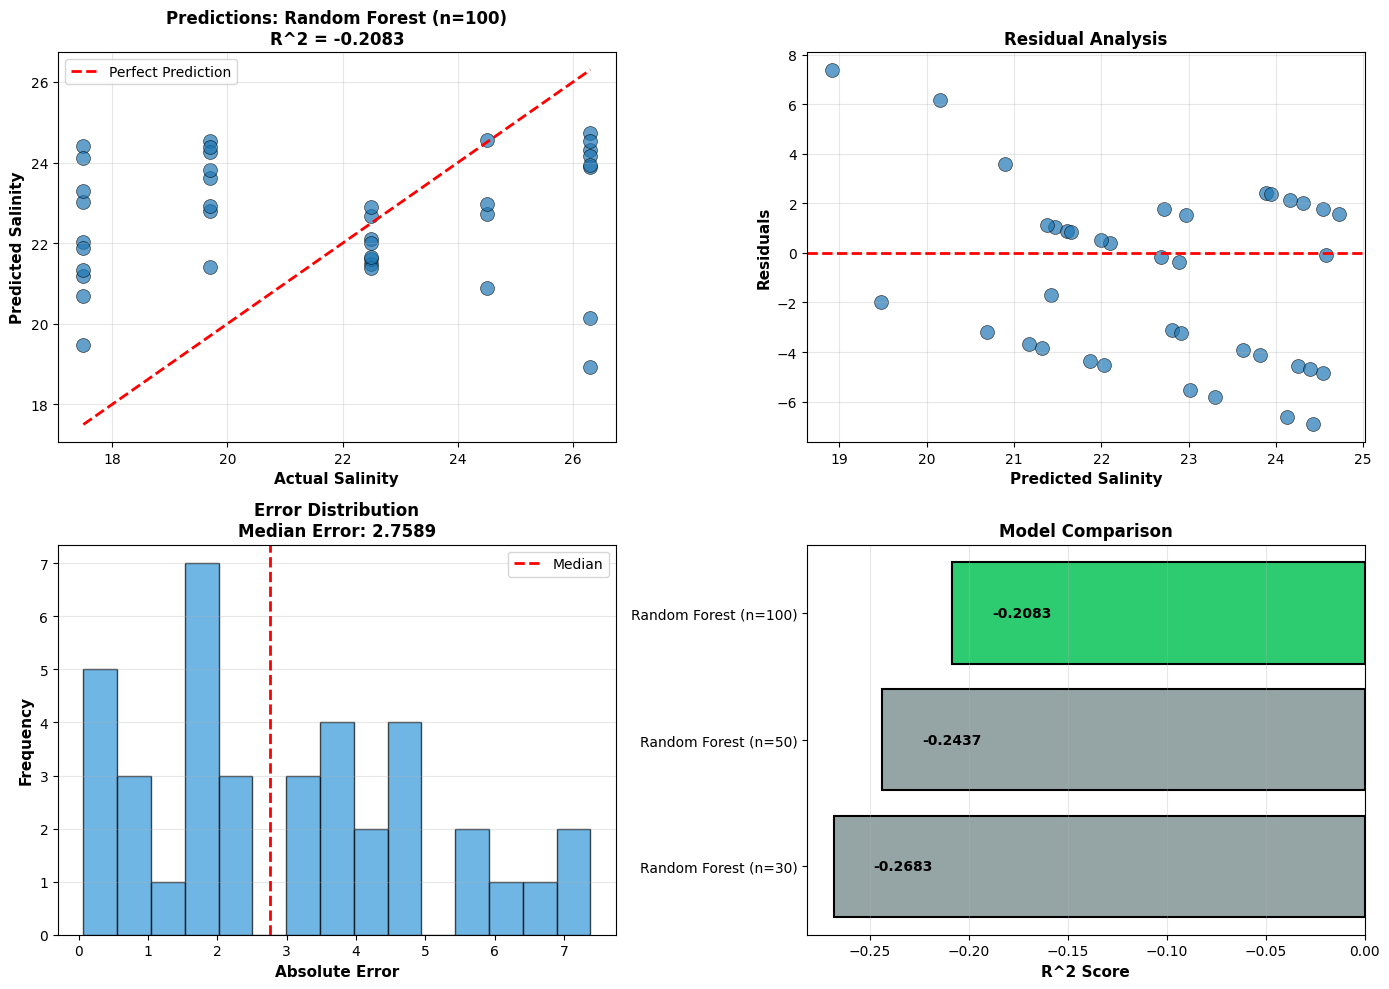

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
ax = axes[0, 0]
ax.scatter(y_test, best_pred, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
min_val, max_val = y_test.min(), y_test.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Salinity', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted Salinity', fontsize=11, fontweight='bold')
ax.set_title(f'Predictions: {best_name}\nR^2 = {results[best_name]["r2"]:.4f}', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Residuals
ax = axes[0, 1]
residuals = y_test - best_pred
ax.scatter(best_pred, residuals, alpha=0.7, s=100, edgecolors='black', linewidths=0.5)
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Predicted Salinity', fontsize=11, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax.set_title('Residual Analysis', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Error distribution
ax = axes[1, 0]
errors_abs = np.abs(y_test - best_pred)
ax.hist(errors_abs, bins=min(15, len(errors_abs)//2), edgecolor='black', alpha=0.7, color='#3498db')
ax.set_xlabel('Absolute Error', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title(f'Error Distribution\nMedian Error: {np.median(errors_abs):.4f}', 
             fontsize=12, fontweight='bold')
ax.axvline(np.median(errors_abs), color='r', linestyle='--', lw=2, label='Median')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Model comparison
ax = axes[1, 1]
model_names = list(results.keys())
r2_scores = [results[m]['r2'] for m in model_names]
colors = ['#2ecc71' if name == best_name else '#95a5a6' for name in model_names]
bars = ax.barh(model_names, r2_scores, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('R^2 Score', fontsize=11, fontweight='bold')
ax.set_title('Model Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add R^2 values on bars
for i, (bar, score) in enumerate(zip(bars, r2_scores)):
    if score > 0.1:
        ax.text(score - 0.05, i, f'{score:.4f}', 
                va='center', ha='right', fontweight='bold', color='white')
    else:
        ax.text(score + 0.02, i, f'{score:.4f}', 
                va='center', ha='left', fontweight='bold')

plt.tight_layout()
#plt.savefig('salinity_model_results.png', dpi=150, bbox_inches='tight')
#print(f"\n Plots saved as 'salinity_model_results.png'")
plt.show()

## Validation

In [ ]:
print(f" R^2 score: {results[best_name]['r2']:.4f} (want > 0.90)")
print(f" MAPE: {results[best_name]['mape']:.2f}% (want < 10%)")
print(f" MAE: {results[best_name]['mae']:.4f}")
if not np.isnan(results[best_name]['cv_mae']):
    cv_diff = abs(results[best_name]['cv_mae'] - results[best_name]['mae'])/results[best_name]['mae']*100
    print(f" CV MAE similar to test MAE: {cv_diff:.1f}% difference")